Visualizing Raw EEG Signals (Before DWT) 


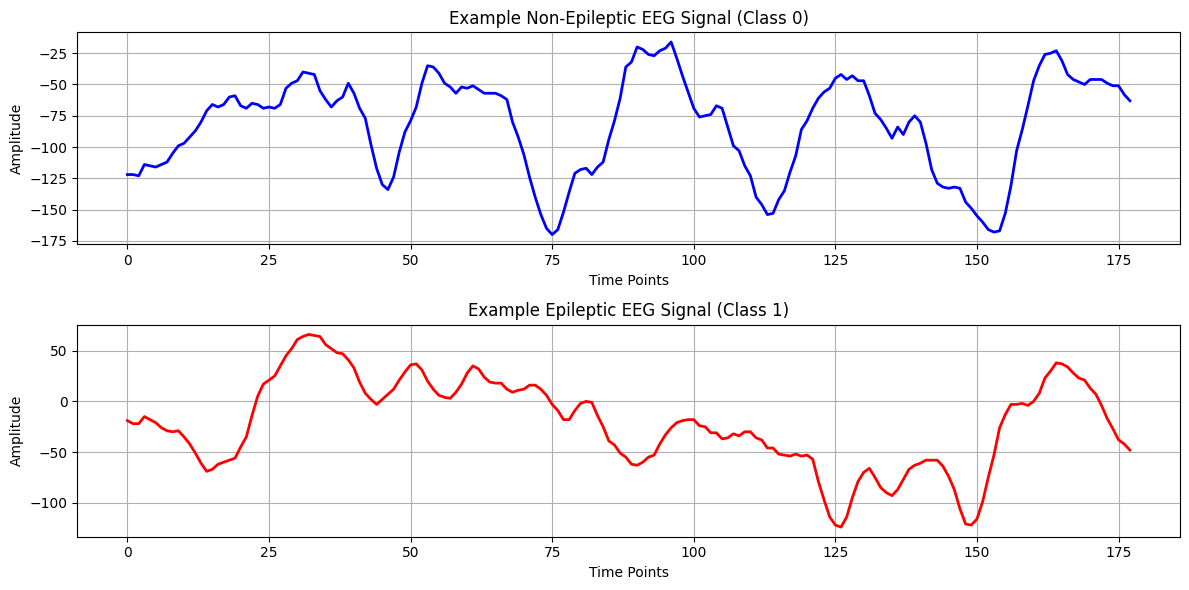

--------------------------------------------------


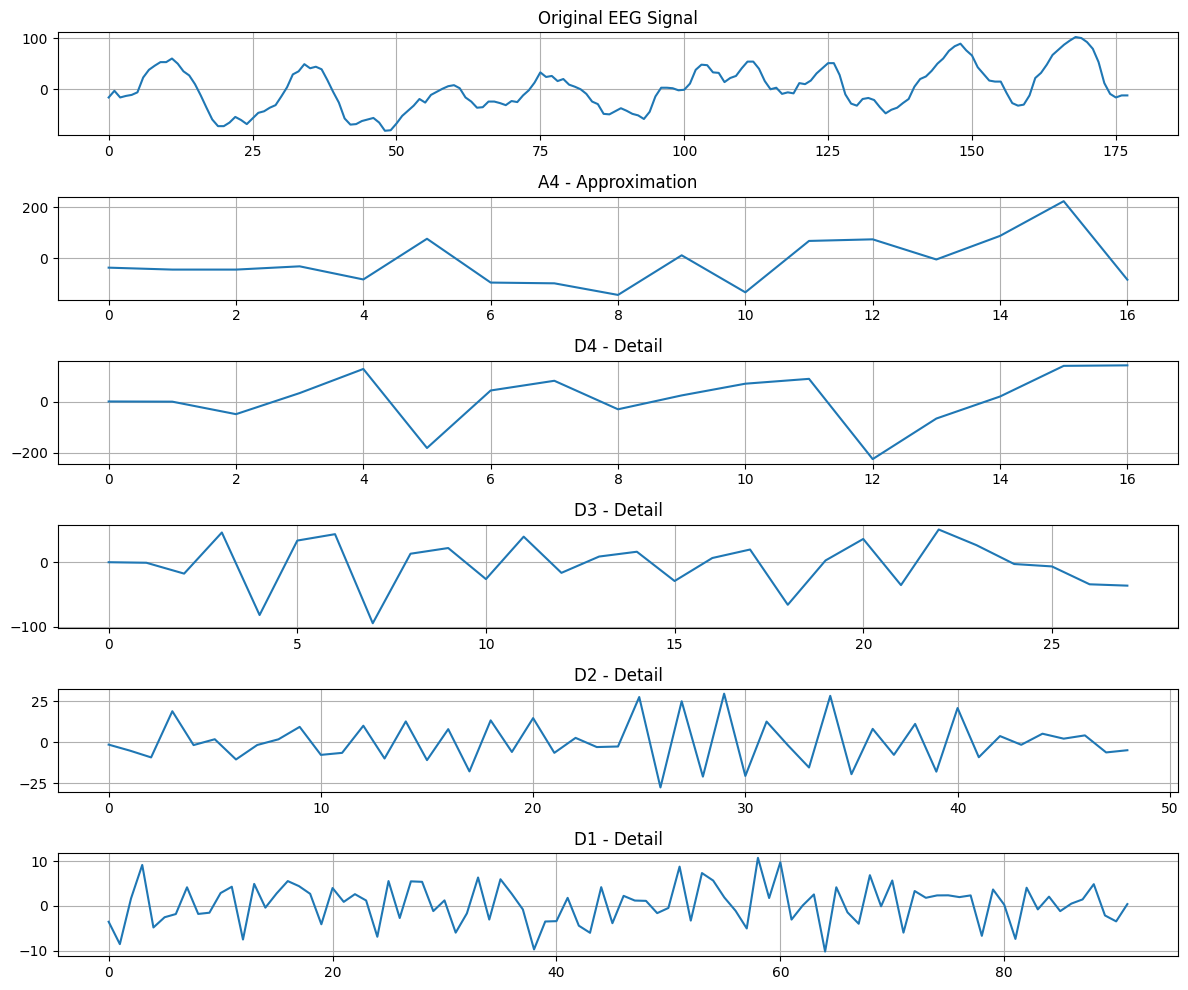

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
311/311 ━━━━━━━━━━━━━━━━━━━━ 67s 183ms/step - accuracy: 0.7781 - loss: 0.5049 - val_accuracy: 0.7251 - val_loss: 1.2192 - learning_rate: 0.0010
Epoch 2/60
311/311 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - accuracy: 0.8264 - loss: 0.3278 - val_accuracy: 0.8261 - val_loss: 0.3157 - learning_rate: 0.0010
Epoch 3/60
311/311 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.8356 - loss: 0.3049 - val_accuracy: 0.8573 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 4/60
311/311 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - accuracy: 0.8556 - loss: 0.2730 - val_accuracy: 0.8524 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 5/60
311/311 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.8566 - loss: 0.2588 - val_accuracy: 0.8664 - val_loss: 0.2456 - learning_rate: 0.0010
Epoch 6/60
311/311 ━━━━━━━━━━━━━━━━━━━━ 60s 193ms/step - accuracy: 0.8660 - loss: 0.2428 - val_accuracy: 0.8727 - val_loss: 0.2310 - learning_rate: 0.0010
Epoch 7/60
311/311 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - accuracy: 0.8

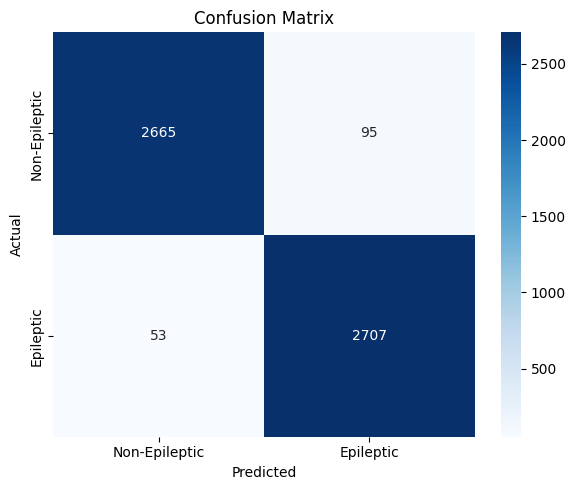

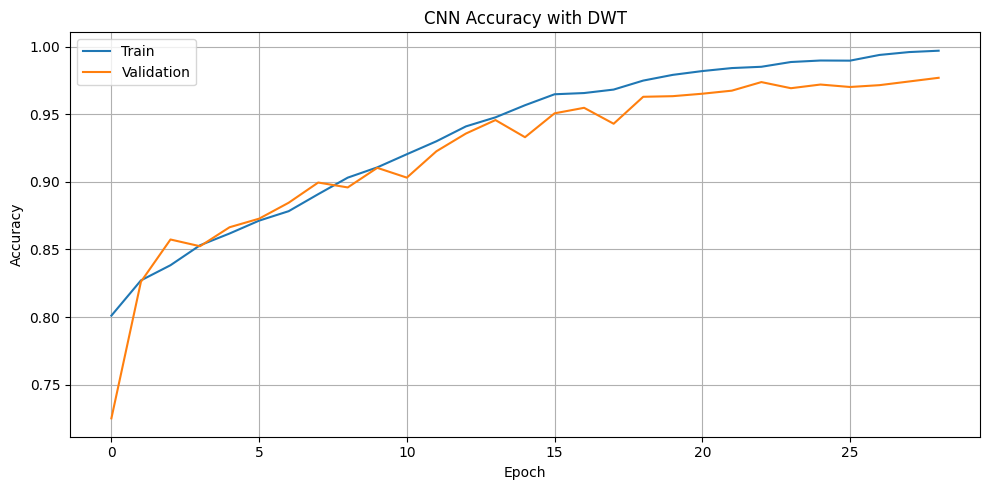

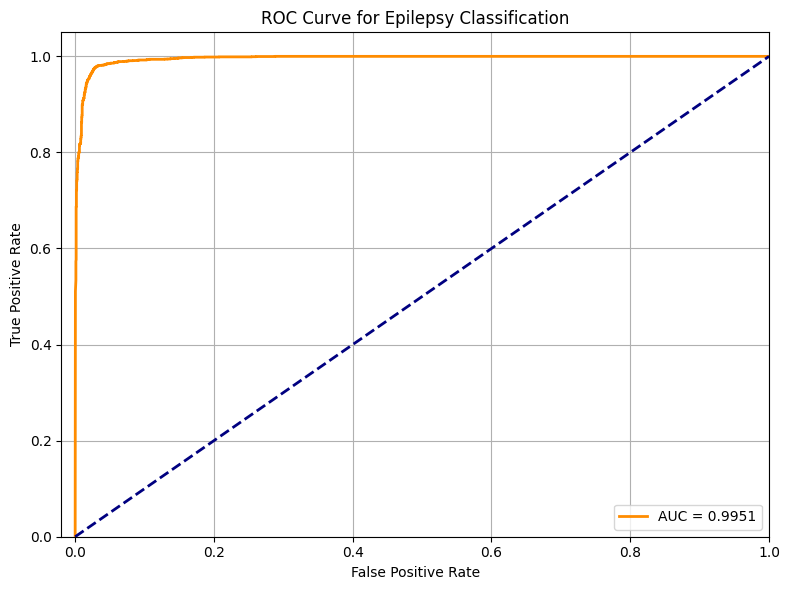

In [1]:
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and clean data
file_path = "CSB_MIT.csv"
df = pd.read_csv(file_path).drop(columns=["Unnamed"])
df['y'] = df['y'].apply(lambda x: 0 if x in [1, 2] else 1)

#  Visualizing Raw EEG Signals (Before DWT) 
print("Visualizing Raw EEG Signals (Before DWT) ")
# Get an example non-epileptic signal (y=0)
non_epileptic_signal = df[df['y'] == 0].drop(columns=['y']).sample(1, random_state=42).iloc[0].values
# Get an example epileptic signal (y=1)
epileptic_signal = df[df['y'] == 1].drop(columns=['y']).sample(1, random_state=42).iloc[0].values

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(non_epileptic_signal, color='blue', linewidth=2) 
plt.title('Example Non-Epileptic EEG Signal (Class 0)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(epileptic_signal, color='red', linewidth=2) 
plt.title('Example Epileptic EEG Signal (Class 1)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()
print("-" * 50)
# DWT
sample_signal = df.drop(columns=['y']).sample(1, random_state=0).values.flatten()
coeffs = pywt.wavedec(sample_signal, wavelet='db4', level=4)
A4, D4, D3, D2, D1 = coeffs

plt.figure(figsize=(12, 10))
plt.subplot(6, 1, 1); plt.plot(sample_signal); plt.title("Original EEG Signal"); plt.grid(True)
plt.subplot(6, 1, 2); plt.plot(A4); plt.title("A4 - Approximation"); plt.grid(True)
plt.subplot(6, 1, 3); plt.plot(D4); plt.title("D4 - Detail"); plt.grid(True)
plt.subplot(6, 1, 4); plt.plot(D3); plt.title("D3 - Detail"); plt.grid(True)
plt.subplot(6, 1, 5); plt.plot(D2); plt.title("D2 - Detail"); plt.grid(True)
plt.subplot(6, 1, 6); plt.plot(D1); plt.title("D1 - Detail"); plt.grid(True)
plt.tight_layout()
plt.savefig("DWT_Decomposition_Plot.png")
plt.show()

# DWT feature extraction
def extract_dwt_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return np.concatenate(coeffs)

X = np.array([extract_dwt_features(row) for row in df.drop(columns=['y']).values])
y = df['y'].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: add noise
def jitter(x, sigma=0.03):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

X_aug = np.vstack([X_scaled, jitter(X_scaled)])
y_aug = np.hstack([y, y])

# SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_aug, y_aug)

# Reshape for CNN
X_balanced = X_balanced.reshape((X_balanced.shape[0], X_balanced.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

# CNN model
model = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=(X_balanced.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(256, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Train
history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_split=0.1,
                    callbacks=[early_stop, reduce_lr], verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

# Predict and classification
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype("int32")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Epileptic", "Epileptic"],
            yticklabels=["Non-Epileptic", "Epileptic"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("Confusion_Matrix.png")
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("CNN Accuracy with DWT")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Accuracy_Curve.png")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Epilepsy Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_Curve.png")
plt.show()
